In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.float_format', '{:.4f}'.format)
%precision 4
%config InlineBackend.figure_format = 'retina'

import yfinance as yf
import requests_cache
session = requests_cache.CachedSession(expire_after='1D')

# Calculate daily returns for the S&P 100 stocks.

In [2]:
wiki = pd.read_html(io='https://en.wikipedia.org/wiki/S%26P_100')
stocks = (
    yf.download(
        tickers=wiki[2]['Symbol'].replace(to_replace='\.', value='-', regex=True).to_list(), 
        start='2020-01-01', 
        end='2022-08-31', 
        session=session
    )
    .rename_axis(columns=['Variable', 'Ticker'])
)
returns = stocks['Adj Close'].pct_change().dropna()

[*********************100%***********************]  101 of 101 completed


# How well do annualized average returns in 2020 predict those in 2021?

In [3]:
df_2 = (
    returns
    .loc['2020':'2021']
    .groupby(lambda x: str(x.year))
    .agg(['mean', 'std'])
    .rename_axis(columns=['Ticker', 'Statistic'])
    .stack(level='Ticker')
    .unstack(level='Date')
)
df_2['mean'] *= 252 * 100
df_2['std'] *= np.sqrt(252) * 100

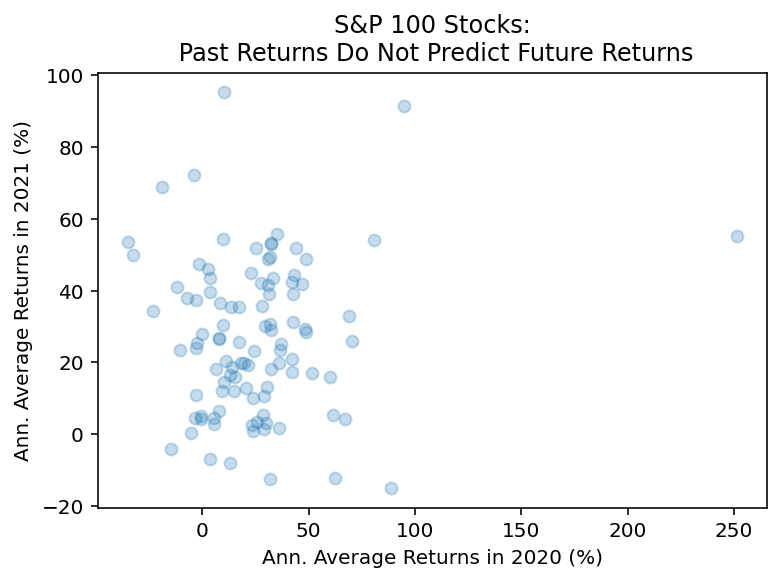

In [4]:
plt.scatter(x=df_2[('mean', '2020')], y=df_2[('mean', '2021')], alpha=0.25)
plt.xlabel('Ann. Average Returns in 2020 (%)')
plt.ylabel('Ann. Average Returns in 2021 (%)')
plt.title('S&P 100 Stocks:\n Past Returns Do Not Predict Future Returns')
plt.show()

In [5]:
df_2['mean'].sort_values('2020').iloc[5:-5].corr().loc['2020', '2021']

-0.0158

# How well do annualized standard deviations of returns in 2020 predict those in 2021?

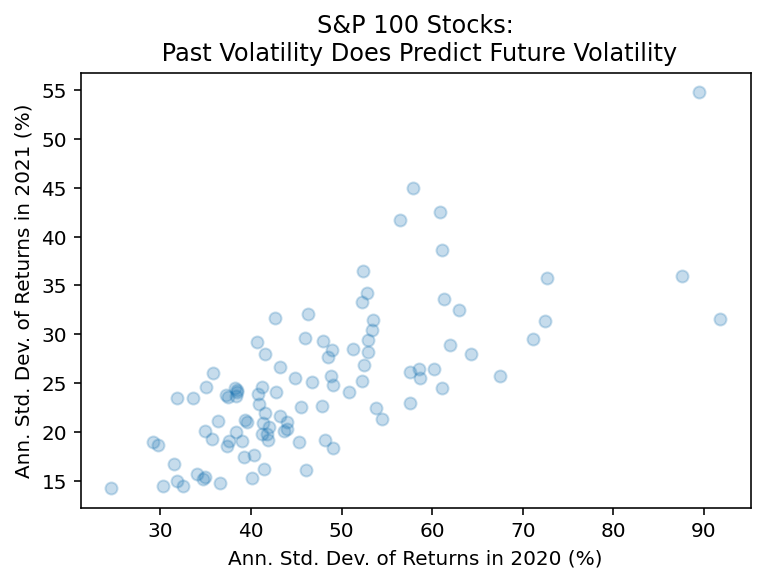

In [6]:
plt.scatter(x=df_2[('std', '2020')], y=df_2[('std', '2021')], alpha=0.25)
plt.xlabel('Ann. Std. Dev. of Returns in 2020 (%)')
plt.ylabel('Ann. Std. Dev. of Returns in 2021 (%)')
plt.title('S&P 100 Stocks:\n Past Volatility Does Predict Future Volatility')
plt.show()

In [7]:
df_2['std'].sort_values('2020').iloc[5:-5].corr().loc['2020', '2021']

0.6281

# What are the mean, median, minimum, and maximum pairwise correlations between two stocks?

In [8]:
corrs = returns.corr()
pairs_to_keep = np.tril(m=corrs, k=-1) != 0
s_4 = corrs.where(pairs_to_keep, np.nan).stack().sort_values()

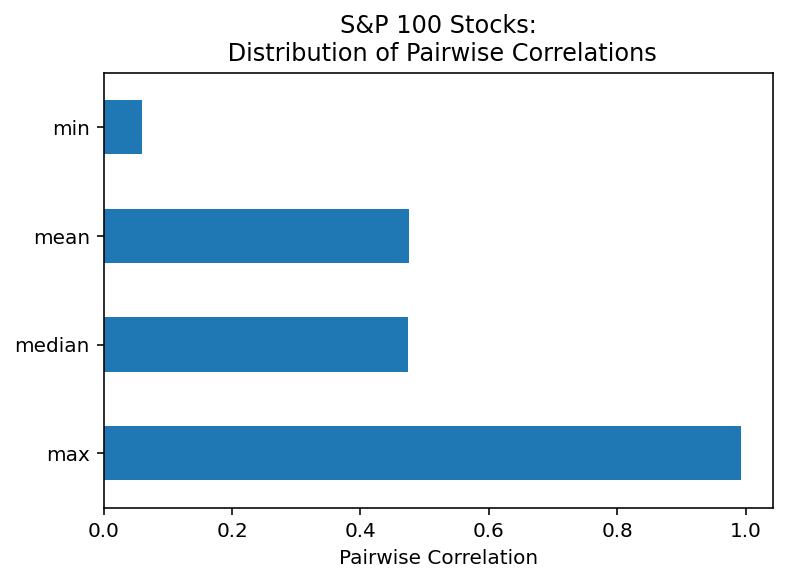

In [9]:
s_4.agg(['min', 'mean', 'median', 'max']).plot(kind='barh')
plt.gca().invert_yaxis()
plt.xlabel('Pairwise Correlation')
plt.title('S&P 100 Stocks:\n Distribution of Pairwise Correlations')
plt.show()

In [10]:
s_4.iloc[[0, 1, 5050//2, -2, -1]]

Ticker  Ticker
VZ      TSLA     0.0600
TMO     SPG      0.0726
WFC     LMT      0.4736
JPM     BAC      0.9377
GOOGL   GOOG     0.9937
dtype: float64

# Plot annualized average returns versus annualized standard deviations of returns.

In [11]:
df_5 = returns.agg(['mean', 'std']).rename_axis(index='Statistic').T
df_5['mean'] *= 252 * 100
df_5['std'] *= np.sqrt(252) * 100

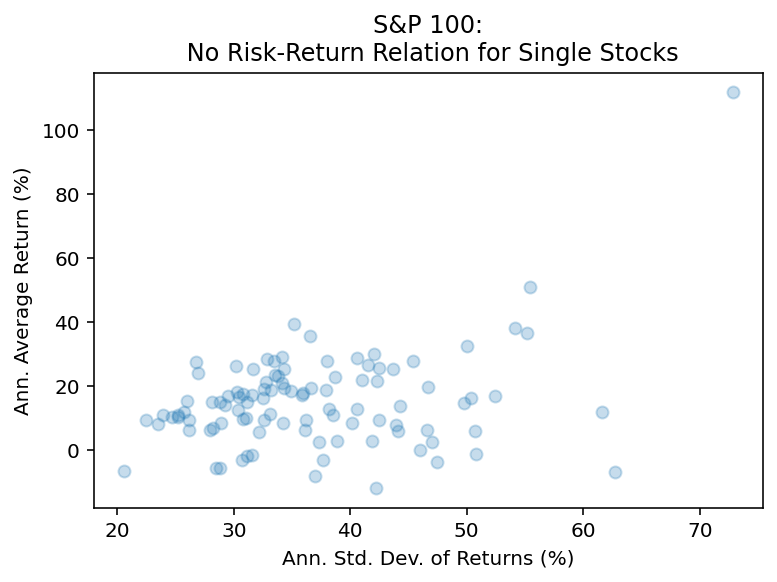

In [12]:
plt.scatter(x=df_5['std'], y=df_5['mean'], alpha=0.25)
plt.ylabel('Ann. Average Return (%)')
plt.xlabel('Ann. Std. Dev. of Returns (%)')
plt.title('S&P 100:\n No Risk-Return Relation for Single Stocks')
plt.show()

In [18]:
df_5.corr().loc['mean', 'std']

0.3494

In [19]:
df_5.sort_values('mean').iloc[5:-5].corr().loc['std', 'mean']

0.0315

In [20]:
import seaborn as sns

<AxesSubplot: xlabel='std', ylabel='mean'>

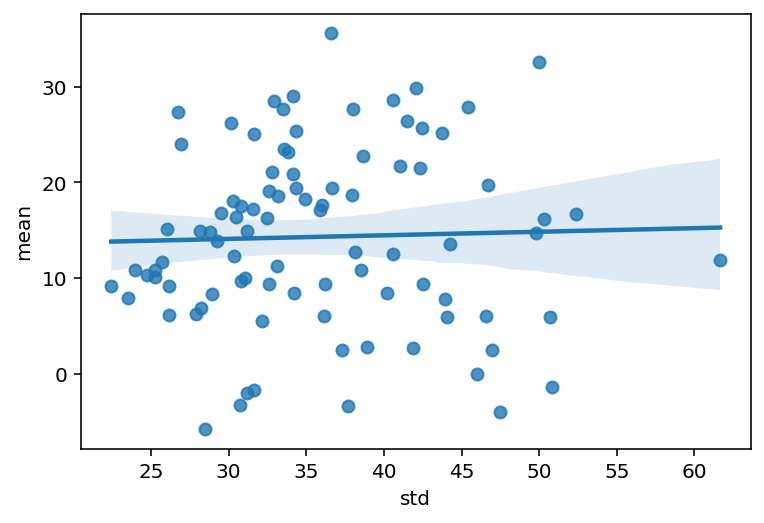

In [23]:
sns.regplot(x='std', y='mean', data=df_5.sort_values('mean').iloc[5:-5])

# Repeat the exercise above (question 5) with 100 random portfolios of 2, 5, 10, and 25 stocks.

In [14]:
def ports(m=2, n=100, data=returns):
    _ports = [data.sample(n=m, axis=1, random_state=i).mean(axis=1) for i in range(n)]
    return pd.concat(objs=_ports, axis=1, keys=range(1, n+1), names='Number')

In [15]:
sizes = [2, 5, 10, 25]
df_6 = (
    pd.concat(objs=[ports(m=s) for s in sizes], keys=sizes, names=['Size', 'Date'])
    .groupby(level='Size')
    .agg(['mean', 'std'])
    .rename_axis(columns=['Number', 'Statistic'])
    .stack(level='Number')
)
df_6['mean'] *= 252 * 100
df_6['std'] *= np.sqrt(252) * 100

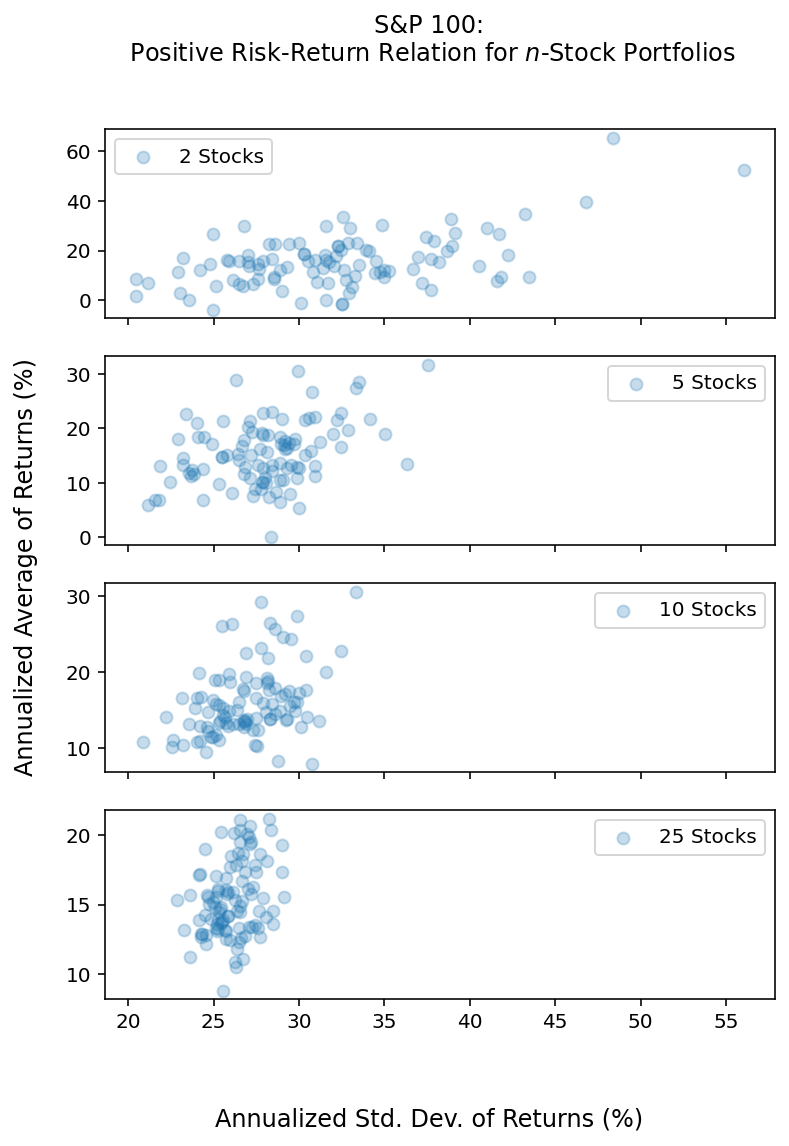

In [16]:
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(6, 8))
for size, group in df_6.groupby(level='Size'):
    axes[sizes.index(size)].scatter(x=group['std'], y=group['mean'], alpha=0.25)
    axes[sizes.index(size)].legend([f'{size} Stocks'])

fig.supylabel('Annualized Average of Returns (%)')
fig.supxlabel('Annualized Std. Dev. of Returns (%)')
fig.suptitle('S&P 100:\n Positive Risk-Return Relation for $n$-Stock Portfolios')
plt.show()